This notebook is to generate hisoric data for us to analyse in a seperate notebook
### To do:
- Add currency conversion
- Add functionality to use objectives other than max sharpe ratio
- Rework actual returns to include the max & minimum returns achieved by the portfolio during the year whic will be useful for analysis

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
#import operator
#from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
#from joblib import Parallel, delayed
#Import our homebrew functions
import DatabaseMainFnc as dmf

pd.options.mode.chained_assignment = None #silences setting with a copy warning
pd.set_option('display.max_columns', 38)
plt.rcParams['figure.figsize'] = [10, 10]


## Load & Validate our price data

In [3]:
%%time
#Load database
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')

#Set date as index
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

#Validate the data 
dmf.priceDB_validation(df_Nasdaq)

#Do currency conversion here 



df_Nasdaq.tail(5)

Connecting database:NASDAQ
Database connected!
---------------------------------------------------------------------
Negative prices are seen in the following assets: 0
Wall time: 4.01 s


AACG   AACQ  AACQU        AAL  AAME  AAOI       AAON        AAPL  \
2021-03-19  5.29  10.31  11.11  24.969999  5.70  8.48  72.339996  119.989998   
2021-03-22  5.01  10.33  11.07  23.830000  5.33  8.48  70.980003  123.389999   
2021-03-23  4.39  10.13  10.74  22.270000  5.14  8.09  70.050003  122.540001   
2021-03-24  4.09  10.05  10.57  21.809999  4.09  7.70  69.470001  120.089996   
2021-03-25  3.97  10.07  10.54  22.770000  3.95  7.84  70.830002  120.589996   

                 AAWW       AAXJ       ABCB       ABCL   ABCM  ABEO   ABGI  \
2021-03-19  59.209999  94.300003  55.980000  31.200001  21.01  2.18  10.01   
2021-03-22  59.500000  94.220001  54.150002  30.580000  20.75  2.04  10.00   
2021-03-23  57.250000  92.470001  51.990002  29.230000  20.48  1.90   9.85   
2021-03-24  55.090000  90.010002  51.650002  27.790001  19.76  1.78   9.76   
2021-03-25  55.540001  90.430000  52.680000  26.580000  19.76  1.88   9.74   

            ABIO        ABMD        ABNB   ABST  ...      ZIONO      ZIONP  \
2021-03-19  4.18  299.809998  194.389999  14.20  ...  27.299999  24.959999   
2021-03-22  4.26  306.160004  195.000000  14.77  ...  27.450001  25.080000   
2021-03-23  3.92  298.619995  187.139999  14.44  ...  27.610001  24.927700   
2021-03-24  3.73  294.209991  178.850006  14.26  ...  27.950001  25.073000   
2021-03-25  3.80  294.140015  176.160004  13.68  ...  27.900000  25.129999   

            ZIOP  ZIXI   ZKIN        ZLAB          ZM   ZNGA   ZNTE  ZNTEU  \
2021-03-19  4.00  7.88  11.20  132.470001  326.260010   9.98  10.07  10.88   
2021-03-22  4.06  7.84  12.35  138.500000  328.500000  10.03  10.12  10.80   
2021-03-23  3.75  7.54  11.03  132.119995  339.760010   9.98   9.99  10.50   
2021-03-24  3.44  7.26  11.22  126.269997  314.959991   9.72   9.96  10.53   
2021-03-25  3.69  7.16  10.35  130.080002  314.850006   9.82   9.98  10.47   

            ZNTEW       ZNTL          ZS  ZSAN       ZUMZ   ZVO   ZWRKU  ZYNE  \
2021-03-19   1.65  43.939999  181.559998  1.42  46.340000  5.87  10.005  5.31   
2021-03-22   1.49  47.930000  182.610001  1.35  43.610001  5.21  10.010  5.11   
2021-03-23   1.30  42.470001  183.000000  1.25  41.900002  4.75   9.990  4.89   
2021-03-24   1.28  40.590000  175.100006  1.13  40.509998  4.48   9.940  4.58   
2021-03-25   1.26  40.110001  172.850006  1.24  43.410000  4.61   9.960  4.76   

             ZYXI  
2021-03-19  16.10  
2021-03-22  15.74  
2021-03-23  15.11  
2021-03-24  14.99  
2021-03-25  15.40  

[5 rows x 4019 columns]

## Define our generator function

In [4]:
def portfolio_generate_test(database,startdate,enddate,p_max=400, min_returns=0.01, s_asset=0, asset_len=50,  silent=True):
    if silent == False:
        print('Running for :'+str(startdate)+' to '+str(enddate))
    # Subset for date range
    df_input=database[startdate:enddate]
    if silent == False:
        print ("Initial number of stocks: "+str(len(df_input.columns)))

    #Check for stocks which are too expensive for us to buy & drop those
    p_now=database.iloc[-1,:]
    df_unaffordable=p_now[p_now>p_max] #we can set max price here maybe as an optional
    l_unaffordable=df_unaffordable.index.tolist()
    df_input.drop(columns=l_unaffordable, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Our max price is : €"+str(p_max))
        print ("Number of stocks to drop due being unnaffordble: "+str(len(l_unaffordable)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    # drop any columns with more than half or more Nas as the models dont like these
    half_length=int(len(df_input)*0.50)
    l_drop=df_input.columns[df_input.iloc[:half_length,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to NAs: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))

    # drop any columns with more  Nas for their last 5 rows as these have been delisted
    l_drop=df_input.columns[df_input.iloc[-5:,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to being delisted: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    #see which stocks have negative returns or low returns in the period & drop those
    df_pct=(df_input.iloc[-1,:].fillna(0) / df_input.iloc[0,:])
    df_pct=df_pct[df_pct<= (min_returns + 1)] #we can set minimum returns here maybe as an optional
    l_pct=df_pct.index.tolist()
    df_input.drop(columns=l_pct, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to Negative returns: "+str(len(l_pct)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))
        print ("Number of days data: "+str(len(df_input)))
        print ("As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)")

    #We will only keep the X best performing assets can make this an optional input
    e_asset=s_asset + asset_len
    df=df_input
    mu = expected_returns.mean_historical_return(df)
    top_stocks = mu.sort_values(ascending=False).index[s_asset:e_asset]
    df = df[top_stocks]

    #Calculate expected annulised returns & annual sample covariance matrix of the daily asset
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Optomise for maximal Sharpe ratio
    ef= EfficientFrontier(mu, S) #Create the Efficient Frontier Object

    #We can try a variety of objectives look at adding this as an input
    weights = ef.max_sharpe()
    #weights = ef.min_volatility()
    #target_volatility=0.1
    #weights = ef.efficient_risk(target_volatility)
    #target_return=0.1
    #weights = ef.efficient_return(target_return)


    cl_weights= ef.clean_weights()
    #print(cl_weights)
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%")
        ef.portfolio_performance(verbose=True)
    expected_portfolio_returns=ef.portfolio_performance()[0]
    volatility=ef.portfolio_performance()[1]
    r_sharpe=ef.portfolio_performance()[2]

    #calculates the actual performance date range work on this
    actual_startdate = pd.to_datetime(enddate) + pd.DateOffset(days=2)
    actual_enddate = pd.to_datetime(actual_startdate) + pd.DateOffset(years=1)

    df_actual=database[actual_startdate:actual_enddate]
    df_actual=df_actual[top_stocks]
    df_yoy=pd.DataFrame(df_actual.iloc[-1,:].fillna(0) / df_actual.iloc[0,:], columns=['yoy_perc'])
    df_yoy['weights']=cl_weights.values()
    df_yoy['weighted_perc']=df_yoy['weights']*df_yoy['yoy_perc']

    #for error checking
    #print(df_actual.iloc[-1,:].fillna(0))
    #print(df_actual.iloc[0,:])
    #print(df_yoy)

    actual_returns=df_yoy['weighted_perc'].sum()-1
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our portfolio performed at : " + str(np.round(actual_returns,3)*100)+"%")
    return [pd.to_datetime(startdate), pd.to_datetime(enddate), expected_portfolio_returns, volatility, r_sharpe, actual_returns]

## Demonstrate the fuction with info displayed

In [5]:
database=df_Nasdaq
startdate=pd.to_datetime("2012-09-01")
enddate=pd.to_datetime("2014-02-01")
portfolio_generate_test(database,startdate,enddate,p_max=250, min_returns=0.01, s_asset=100, asset_len=50, silent=False)

Running for :2012-09-01 00:00:00 to 2014-02-01 00:00:00
Initial number of stocks: 4019
-----------------------------------------------------
Our max price is : €250
Number of stocks to drop due being unnaffordble: 67
Number of stocks remaining: 3952
-----------------------------------------------------
Number of stocks due to NAs: 2196
Number of stocks remaining: 1756
-----------------------------------------------------
Number of stocks due to being delisted: 2
Number of stocks remaining: 1754
-----------------------------------------------------
Number of stocks due to Negative returns: 321
Number of stocks remaining: 1433
Number of days data: 355
As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)
-------------------------------------------------------------
Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%
Expected annual return: 115.8%
Annual volatility: 12.4%
Sharpe Rat

[Timestamp('2012-09-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 1.1576168932412574,
 0.12369768198095486,
 9.196751911781263,
 0.14533425022768798]

In [7]:
%%time
#set or inputs & create empty lists for output
database=df_Nasdaq

#vary start date but beware its an N! problem need to speed this up if we can
startdate=pd.to_datetime("2010-01-01")
enddate=pd.to_datetime("2020-01-01")
a_test=[]
col_s_assets=[]
t_start=startdate
t_end=enddate

#vary start asset 0 takes the top 50 assets , 50 takes 50-99,.... this is an N problem which isnt too bad
l_s_asset=np.arange(0,550,50)

# runnings through starting assets, as we create portfolios for only 50 assets at a time (this can be varied)
for strt in l_s_asset: 
    t_start=startdate
    t_end=enddate
    print('Running for s_asset : '+ str(strt))

    # iterates through start dates by adding one month each time until theres 1 year between the start & end date
    while t_start + pd.DateOffset(years=1) <= t_end:
        a_test.append(portfolio_generate_test(database,t_start,t_end,s_asset=strt,asset_len=50))
        col_s_assets.append(strt)
        t_start=t_start + pd.DateOffset(months=1)

        #when our start date is 1 year from the end date subtract 1 year from the enddate & reset the start date
        if t_start + pd.DateOffset(years=1) == t_end:
            t_start=startdate
            t_end=t_end - pd.DateOffset(months=1)

#put all this data in a pandas datafame and save it             
df_test=pd.DataFrame(a_test,columns=['Start_Date','End_date','Expected_returns','volatility', 'sharpe_ratio','Actual_returns'])
df_test['starting_asset']=col_s_assets
df_test.to_csv('Nasdaq_Performance_data.csv')

Running for s_asset : 0
C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:88: UserWarning: Could not fix matrix. Please try a different risk model.
  "Could not fix matrix. Please try a different risk model.", UserWarning
Running for s_asset : 50
Running for s_asset : 100
Running for s_asset : 150
Running for s_asset : 200
Running for s_asset : 250
Running for s_asset : 300
Running for s_asset : 350
Running for s_asset : 400
Running for s_asset : 450
Running for s_asset : 500
Wall time: 2h 40min 34s


## Preview our data , more detailed analysis will be done in a seperate notebook

In [8]:
print("Actual returns should be greater than -1, we have : "+str(df_test['Actual_returns'].min()))
df_test.tail(3)

-0.5955191609766648


Start_Date   End_date  Expected_returns  volatility  sharpe_ratio  \
64752 2010-03-01 2011-04-01          0.332880    0.100204      3.122425   
64753 2010-01-01 2011-03-01          0.303460    0.089350      3.172454   
64754 2010-02-01 2011-03-01          0.346663    0.104142      3.136724   
64755 2010-01-01 2011-02-01          0.306064    0.093726      3.052138   
64756 2010-01-01 2011-01-01          0.292564    0.105642      2.580073   

       Actual_returns  starting_asset  
64752        0.026574             500  
64753        0.069171             500  
64754        0.051460             500  
64755       -0.014864             500  
64756        0.053693             500

(-1, 6)

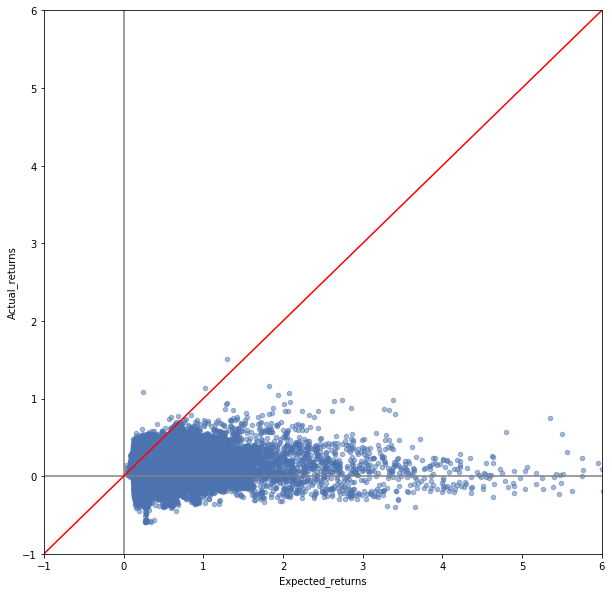

In [9]:
# Plot expected vs actual scatter
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='Expected_returns', y='Actual_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])